In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc
)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from imblearn.over_sampling import SMOTE


In [2]:
df = pd.read_csv(r"F:\pbl research\new research paper\Sarcasm_combined.csv")
print(df.head())

             tweet_id                                               text label
0  866871160725794816          Triple Talaq par Burbak Kuchh nahi bolega    NO
1  880356789358743553  Batao ye uss site pr se akki sir ke verdict ni...   YES
2  877751493889105920  Hindu baheno par julam bardas nahi hoga @Tripl...    NO
3  901806457871466496  Naa bhai.. aisa nhi hai.. mere handle karne se...    NO
4  866264330748219392  #RememberingRajiv aaj agar musalman auraten tr...    NO


In [3]:
df["label"] = df["label"].map({"YES": 1, "NO": 0})

In [4]:
# Shape of dataset
print("Dataset Shape:", df.shape)

# Show column names
print("Columns:", df.columns.tolist())

# Check missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Display few samples
df.head()


Dataset Shape: (5250, 3)
Columns: ['tweet_id', 'text', 'label']

Missing Values:
tweet_id    0
text        0
label       0
dtype: int64


,tweet_id,text,label
0,866871160725794816,Triple Talaq par Burbak Kuchh nahi bolega,0
1,880356789358743553,Batao ye uss site pr se akki sir ke verdict ni...,1
2,877751493889105920,Hindu baheno par julam bardas nahi hoga @Tripl...,0
3,901806457871466496,Naa bhai.. aisa nhi hai.. mere handle karne se...,0
4,866264330748219392,#RememberingRajiv aaj agar musalman auraten tr...,0


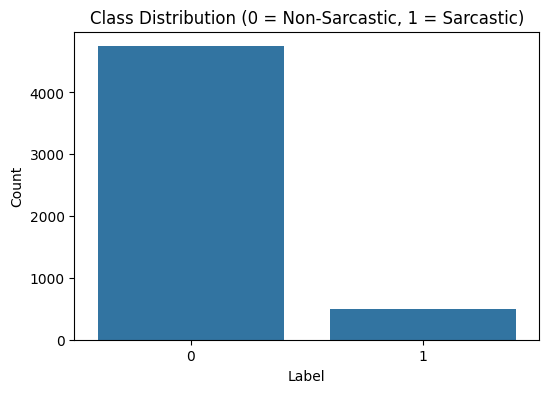

label
0    4746
1     504
Name: count, dtype: int64


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x=df['label'])
plt.title("Class Distribution (0 = Non-Sarcastic, 1 = Sarcastic)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

print(df['label'].value_counts())


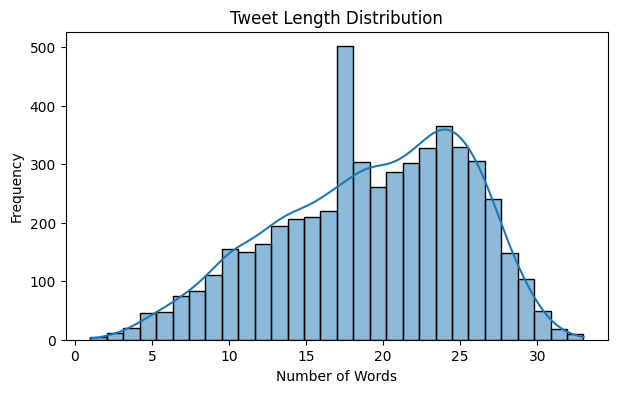

count    5250.000000
mean       19.232762
std         6.170647
min         1.000000
25%        15.000000
50%        20.000000
75%        24.000000
max        33.000000
Name: text_length, dtype: float64

In [6]:
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(7,4))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title("Tweet Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

df['text_length'].describe()


In [7]:
from collections import Counter
import re

def tokenize(text):
    tokens = re.findall(r'\b\w+\b', text.lower())
    return tokens

all_tokens = df['text'].apply(tokenize)

counter = Counter()
for tokens in all_tokens:
    counter.update(tokens)

common_words = counter.most_common(20)
common_words


[('hai', 3734),
 ('ki', 1890),
 ('ko', 1542),
 ('politics', 1518),
 ('ke', 1410),
 ('bhi', 1245),
 ('se', 1244),
 ('to', 1169),
 ('aur', 1168),
 ('cricket', 1134),
 ('ka', 1122),
 ('ho', 1053),
 ('nahi', 1026),
 ('talaq', 1025),
 ('me', 980),
 ('triple', 956),
 ('k', 702),
 ('ye', 681),
 ('hi', 656),
 ('bollywood', 598)]

In [8]:
def get_top_words(class_label, n=15):
    text = " ".join(df[df['label']==class_label]['text'])
    tokens = tokenize(text)
    counts = Counter(tokens)
    return counts.most_common(n)

print("Top words for NON-SARCASTIC:")
print(get_top_words(0))

print("\nTop words for SARCASTIC:")
print(get_top_words(1))


Top words for NON-SARCASTIC:
[('hai', 3406), ('ki', 1730), ('politics', 1517), ('ko', 1433), ('ke', 1291), ('bhi', 1160), ('se', 1157), ('cricket', 1134), ('to', 1083), ('aur', 1052), ('ka', 1037), ('talaq', 1025), ('ho', 979), ('triple', 956), ('nahi', 942)]

Top words for SARCASTIC:
[('hai', 328), ('irony', 299), ('sarcasm', 188), ('ki', 160), ('ke', 119), ('aur', 116), ('ko', 109), ('hain', 102), ('se', 87), ('to', 86), ('bhi', 85), ('ka', 85), ('nahi', 84), ('ho', 74), ('mein', 65)]


In [9]:
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Function to normalize elongated words (ex: soooo → soo)
def reduce_elongated(word):
    return re.sub(r'(.)\1{2,}', r'\1\1', word)

def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Remove mentions (@username)
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags (#word → word)
    text = re.sub(r'#', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Tokenize
    words = text.split()
    
    cleaned_tokens = []
    for w in words:
        # Reduce elongated words (ex: "goooood" → "good")
        w = reduce_elongated(w)
        
        # Remove stopwords
        if w not in stop_words:
            # Lemmatize
            w = lemmatizer.lemmatize(w)
            cleaned_tokens.append(w)
    
    return " ".join(cleaned_tokens)

# Apply preprocessing to your dataset
df["clean_text"] = df["text"].apply(clean_text)

df[["text", "clean_text"]].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Charvi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Charvi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,clean_text
0,Triple Talaq par Burbak Kuchh nahi bolega,triple talaq par burbak kuchh nahi bolega
1,Batao ye uss site pr se akki sir ke verdict ni...,batao ye us site pr se akki sir ke verdict nik...
2,Hindu baheno par julam bardas nahi hoga @Tripl...,hindu baheno par julam bardas nahi hoga hindu ...
3,Naa bhai.. aisa nhi hai.. mere handle karne se...,naa bhai aisa nhi hai mere handle karne se bhi...
4,#RememberingRajiv aaj agar musalman auraten tr...,rememberingrajiv aaj agar musalman auraten tri...


In [10]:
X = df['text']         # your text column name
y = df['label']        # your label column (0/1)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# Check class distribution after split
print("Training set class distribution:\n", y_train.value_counts())
print("Testing set class distribution:\n", y_test.value_counts())

Training set class distribution:
 label
0    3797
1     403
Name: count, dtype: int64
Testing set class distribution:
 label
0    949
1    101
Name: count, dtype: int64


In [12]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    stop_words='english'
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [13]:
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_vec, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_sm.value_counts())


Before SMOTE: label
0    3797
1     403
Name: count, dtype: int64
After SMOTE: label
1    3797
0    3797
Name: count, dtype: int64


In [14]:
lr = LogisticRegression(class_weight='balanced', max_iter=300)
lr.fit(X_train_sm, y_train_sm)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,300
,multi_class,'deprecated'


Training Accuracy (LR): 0.9799841980510929
Testing Accuracy (LR): 0.9457142857142857

Classification Report (LR):
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       949
           1       0.67      0.84      0.75       101

    accuracy                           0.95      1050
   macro avg       0.83      0.90      0.86      1050
weighted avg       0.95      0.95      0.95      1050



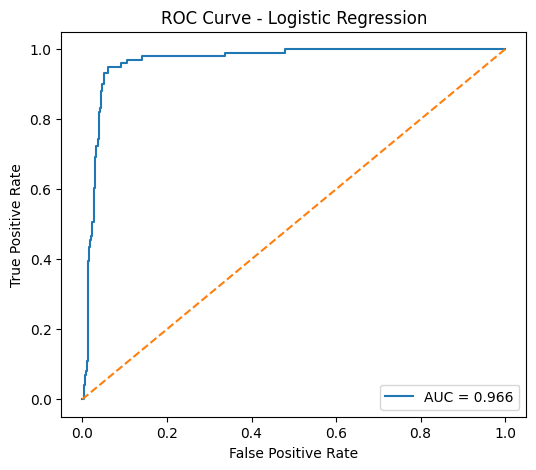

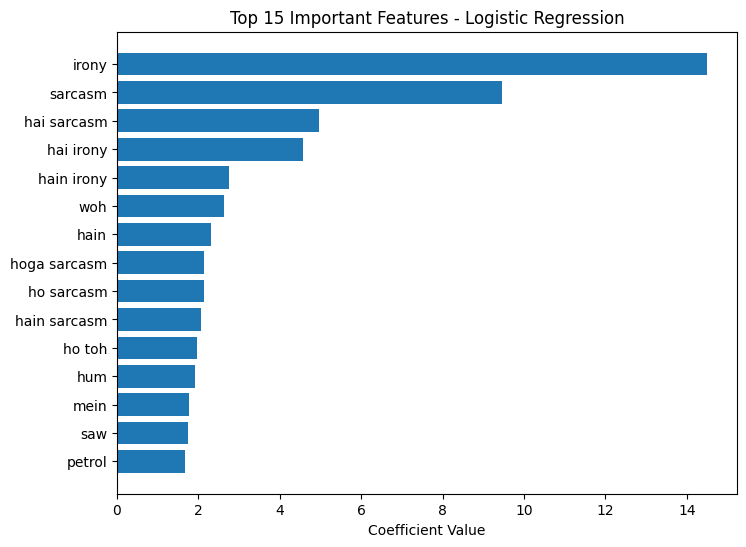


Top 15 Important Features - Logistic Regression

irony                 ->  Weight: 14.5046
sarcasm               ->  Weight: 9.4655
hai sarcasm           ->  Weight: 4.9588
hai irony             ->  Weight: 4.5595
hain irony            ->  Weight: 2.7522
woh                   ->  Weight: 2.6279
hain                  ->  Weight: 2.3101
hoga sarcasm          ->  Weight: 2.1342
ho sarcasm            ->  Weight: 2.1258
hain sarcasm          ->  Weight: 2.0605
ho toh                ->  Weight: 1.9564
hum                   ->  Weight: 1.9261
mein                  ->  Weight: 1.7600
saw                   ->  Weight: 1.7335
petrol                ->  Weight: 1.6689


In [15]:

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, auc

# -------------------------
# Predictions
# -------------------------
y_train_pred_lr = lr.predict(X_train_sm)        
y_pred_lr = lr.predict(X_test_vec)              
y_proba_lr = lr.predict_proba(X_test_vec)[:, 1] 

# -------------------------
# Training & Testing Accuracy
# -------------------------
train_accuracy_lr = accuracy_score(y_train_sm, y_train_pred_lr)
test_accuracy_lr  = accuracy_score(y_test, y_pred_lr)

print("Training Accuracy (LR):", train_accuracy_lr)
print("Testing Accuracy (LR):", test_accuracy_lr)

# -------------------------
# Classification Report
# -------------------------
print("\nClassification Report (LR):")
print(classification_report(y_test, y_pred_lr))

# -------------------------
# ROC Curve + AUC
# -------------------------
fpr, tpr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_lr = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_lr:.3f}")
plt.plot([0, 1], [0, 1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

# -------------------------
# Top 15 Features (Logistic Regression)
# -------------------------
feature_names = np.array(vectorizer.get_feature_names_out())
coeffs = lr.coef_[0]

top15_idx = np.argsort(coeffs)[-15:]
top15_features = feature_names[top15_idx]
top15_values = coeffs[top15_idx]

plt.figure(figsize=(8,6))
plt.barh(top15_features, top15_values)
plt.title("Top 15 Important Features - Logistic Regression")
plt.xlabel("Coefficient Value")
plt.show()

# ----------- PRINT TOP 15 FEATURES -----------
print("\nTop 15 Important Features - Logistic Regression\n")
for feature, value in zip(top15_features[::-1], top15_values[::-1]):
    print(f"{feature:20s}  ->  Weight: {value:.4f}")


SVM Training Accuracy: 0.9981564392941796
SVM Testing Accuracy: 0.9361904761904762

Classification Report (SVM):
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       949
           1       0.75      0.50      0.60       101

    accuracy                           0.94      1050
   macro avg       0.85      0.74      0.78      1050
weighted avg       0.93      0.94      0.93      1050



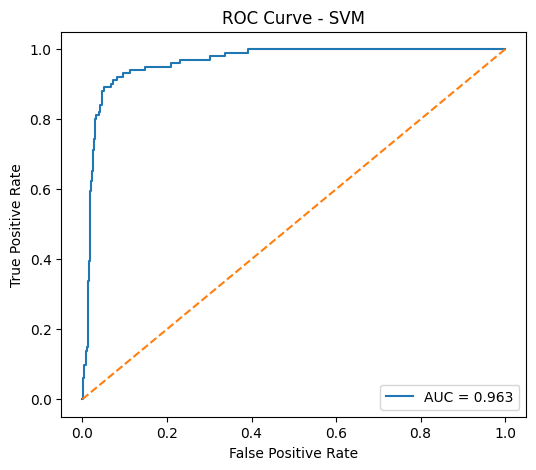

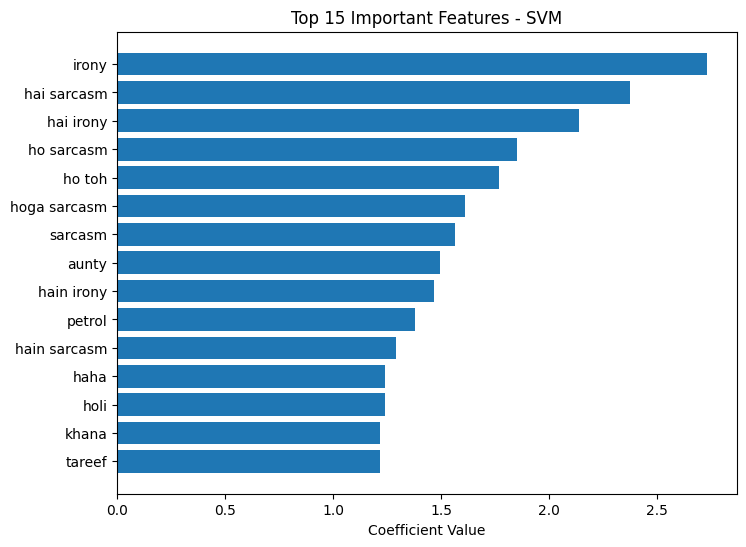


Top 15 Important Features - SVM

irony                 ->  Weight: 2.7317
hai sarcasm           ->  Weight: 2.3726
hai irony             ->  Weight: 2.1378
ho sarcasm            ->  Weight: 1.8489
ho toh                ->  Weight: 1.7681
hoga sarcasm          ->  Weight: 1.6092
sarcasm               ->  Weight: 1.5644
aunty                 ->  Weight: 1.4951
hain irony            ->  Weight: 1.4664
petrol                ->  Weight: 1.3806
hain sarcasm          ->  Weight: 1.2926
haha                  ->  Weight: 1.2406
holi                  ->  Weight: 1.2384
khana                 ->  Weight: 1.2173
tareef                ->  Weight: 1.2169


In [16]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Train SVM with class weight
svm = LinearSVC(class_weight='balanced')
svm_calibrated = CalibratedClassifierCV(svm)
svm_calibrated.fit(X_train_sm, y_train_sm)

# -------------------------
# Predictions
# -------------------------
y_train_pred_svm = svm_calibrated.predict(X_train_sm)
y_pred_svm = svm_calibrated.predict(X_test_vec)
y_proba_svm = svm_calibrated.predict_proba(X_test_vec)[:,1]

# -------------------------
# Accuracies
# -------------------------
train_accuracy_svm = accuracy_score(y_train_sm, y_train_pred_svm)
test_accuracy_svm = accuracy_score(y_test, y_pred_svm)

print("SVM Training Accuracy:", train_accuracy_svm)
print("SVM Testing Accuracy:", test_accuracy_svm)

# -------------------------
# Classification Report
# -------------------------
print("\nClassification Report (SVM):")
print(classification_report(y_test, y_pred_svm))

# -------------------------
# ROC Curve
# -------------------------
fpr, tpr, _ = roc_curve(y_test, y_proba_svm)
roc_auc_svm = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_svm:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM")
plt.legend()
plt.show()

#print(svm_calibrated.__dict__.keys())


# -------------------------
# Top 15 Features (SVM)
# -------------------------
# Extract the underlying LinearSVC model
svm_model_inner = svm_calibrated.calibrated_classifiers_[0].estimator

# Extract coefficients
coeffs = svm_model_inner.coef_[0]
feature_names = np.array(vectorizer.get_feature_names_out())

top15_idx = np.argsort(coeffs)[-15:]
top15_features = feature_names[top15_idx]
top15_values = coeffs[top15_idx]

plt.figure(figsize=(8,6))
plt.barh(top15_features, top15_values)
plt.title("Top 15 Important Features - SVM")
plt.xlabel("Coefficient Value")
plt.show()

# ----------- PRINT TOP 15 FEATURES -----------
print("\nTop 15 Important Features - SVM\n")
for feature, value in zip(top15_features[::-1], top15_values[::-1]):
    print(f"{feature:20s}  ->  Weight: {value:.4f}")


NB Training Accuracy: 0.9761653937318936
NB Testing Accuracy: 0.9238095238095239

Classification Report (Naive Bayes):
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       949
           1       0.58      0.77      0.66       101

    accuracy                           0.92      1050
   macro avg       0.78      0.86      0.81      1050
weighted avg       0.94      0.92      0.93      1050



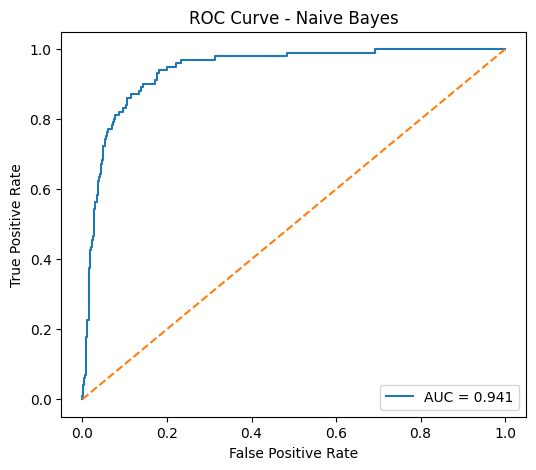

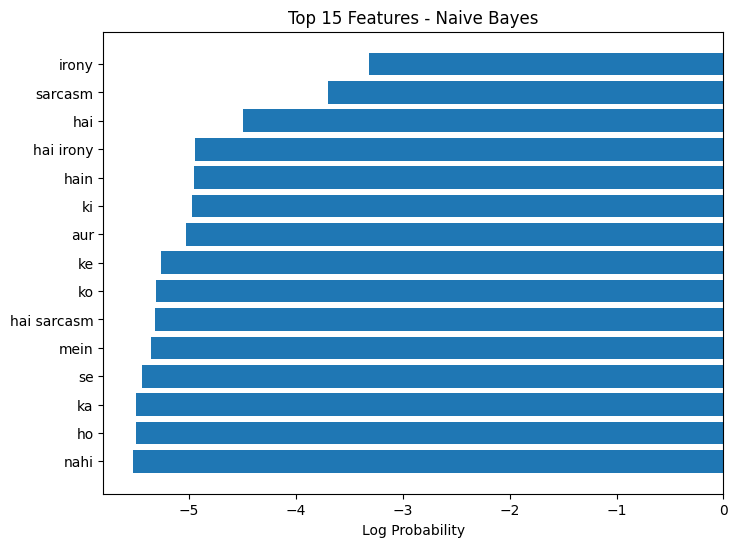


Top 15 Features - Naive Bayes :

irony                 ->  Weight: -3.3137
sarcasm               ->  Weight: -3.7015
hai                   ->  Weight: -4.4928
hai irony             ->  Weight: -4.9386
hain                  ->  Weight: -4.9486
ki                    ->  Weight: -4.9676
aur                   ->  Weight: -5.0268
ke                    ->  Weight: -5.2636
ko                    ->  Weight: -5.3108
hai sarcasm           ->  Weight: -5.3198
mein                  ->  Weight: -5.3493
se                    ->  Weight: -5.4365
ka                    ->  Weight: -5.4929
ho                    ->  Weight: -5.4952
nahi                  ->  Weight: -5.5220


In [17]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_sm, y_train_sm)

# -------------------------
# Predictions
# -------------------------
y_train_pred_nb = nb.predict(X_train_sm)
y_pred_nb = nb.predict(X_test_vec)
y_proba_nb = nb.predict_proba(X_test_vec)[:,1]

# -------------------------
# Accuracies
# -------------------------
train_accuracy_nb = accuracy_score(y_train_sm, y_train_pred_nb)
test_accuracy_nb = accuracy_score(y_test, y_pred_nb)

print("NB Training Accuracy:", train_accuracy_nb)
print("NB Testing Accuracy:", test_accuracy_nb)

# -------------------------
# Classification Report
# -------------------------
print("\nClassification Report (Naive Bayes):")
print(classification_report(y_test, y_pred_nb))

# -------------------------
# ROC Curve
# -------------------------
fpr, tpr, _ = roc_curve(y_test, y_proba_nb)
roc_auc_nb = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_nb:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Naive Bayes")
plt.legend()
plt.show()

# -------------------------
# Top 15 Features (Naive Bayes)
# Uses log probabilities
# -------------------------
# Top 15 Features for Naive Bayes (using feature_log_prob_)
log_prob = nb.feature_log_prob_[1]   # log probability for class 1

feature_names = np.array(vectorizer.get_feature_names_out())

top15_idx = np.argsort(log_prob)[-15:]
top15_features = feature_names[top15_idx]
top15_values = log_prob[top15_idx]

plt.figure(figsize=(8,6))
plt.barh(top15_features, top15_values)
plt.title("Top 15 Features - Naive Bayes")
plt.xlabel("Log Probability")
plt.show()

# ----------- PRINT TOP 15 FEATURES -----------
print("\nTop 15 Features - Naive Bayes :\n")
for feature, value in zip(top15_features[::-1], top15_values[::-1]):
    print(f"{feature:20s}  ->  Weight: {value:.4f}")


RF Training Accuracy: 0.9992099025546484
RF Testing Accuracy: 0.9476190476190476

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       949
           1       0.76      0.66      0.71       101

    accuracy                           0.95      1050
   macro avg       0.86      0.82      0.84      1050
weighted avg       0.95      0.95      0.95      1050



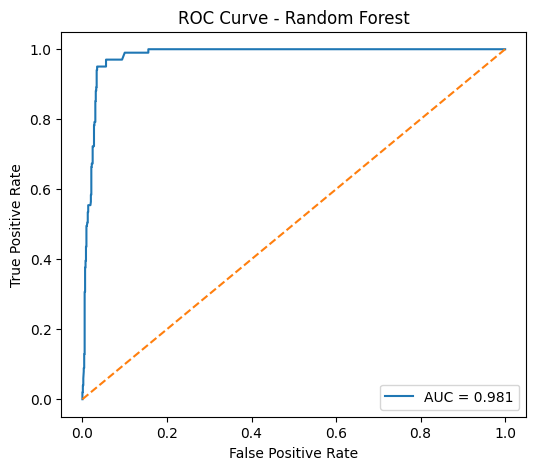

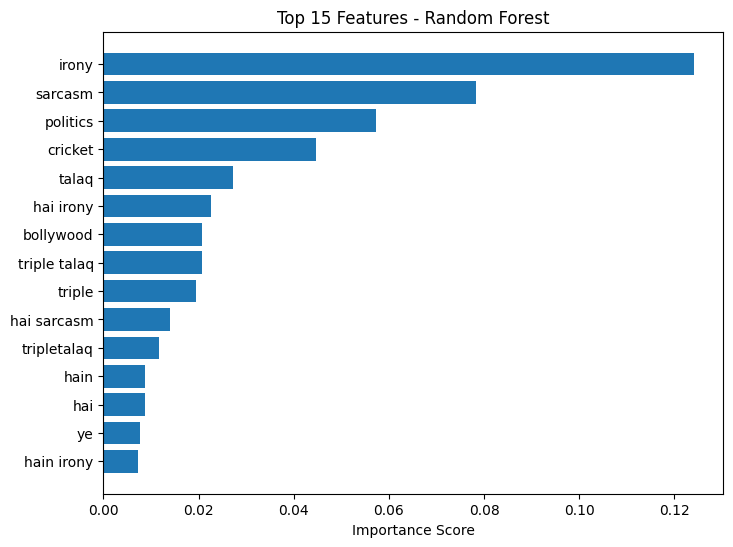


Top 15 Features - Random Forest

irony                 ->  Weight: 0.1241
sarcasm               ->  Weight: 0.0783
politics              ->  Weight: 0.0573
cricket               ->  Weight: 0.0448
talaq                 ->  Weight: 0.0273
hai irony             ->  Weight: 0.0227
bollywood             ->  Weight: 0.0208
triple talaq          ->  Weight: 0.0207
triple                ->  Weight: 0.0194
hai sarcasm           ->  Weight: 0.0139
tripletalaq           ->  Weight: 0.0117
hain                  ->  Weight: 0.0088
hai                   ->  Weight: 0.0087
ye                    ->  Weight: 0.0076
hain irony            ->  Weight: 0.0074


In [18]:

from sklearn.ensemble import RandomForestClassifier

# Train RF
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced')
rf.fit(X_train_sm, y_train_sm)

# -------------------------
# Predictions
# -------------------------
y_train_pred_rf = rf.predict(X_train_sm)
y_pred_rf = rf.predict(X_test_vec)
y_proba_rf = rf.predict_proba(X_test_vec)[:,1]

# -------------------------
# Accuracies
# -------------------------
train_accuracy_rf = accuracy_score(y_train_sm, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("RF Training Accuracy:", train_accuracy_rf)
print("RF Testing Accuracy:", test_accuracy_rf)

# -------------------------
# Classification Report
# -------------------------
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

# -------------------------
# ROC Curve
# -------------------------
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_rf:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

# -------------------------
# Top 15 Features (Random Forest)
# -------------------------
importances = rf.feature_importances_
top15_idx = np.argsort(importances)[-15:]
top15_features = feature_names[top15_idx]
top15_values = importances[top15_idx]

plt.figure(figsize=(8,6))
plt.barh(top15_features, top15_values)
plt.title("Top 15 Features - Random Forest")
plt.xlabel("Importance Score")
plt.show()

# ----------- PRINT TOP 15 FEATURES -----------
print("\nTop 15 Features - Random Forest\n")
for feature, value in zip(top15_features[::-1], top15_values[::-1]):
    print(f"{feature:20s}  ->  Weight: {value:.4f}")



In [20]:
from sklearn.metrics import f1_score
import pandas as pd

# F1 scores
f1_lr = f1_score(y_test, y_pred_lr)
f1_svm = f1_score(y_test, y_pred_svm)
f1_rf = f1_score(y_test, y_pred_rf)
f1_nb = f1_score(y_test, y_pred_nb)

# Create comparison table
comparison_df = pd.DataFrame({
    "Model": ["Logistic Regression", "SVM", "Random Forest", "Naive Bayes"],
    
    
    "Accuracy": [
        test_accuracy_lr,
        test_accuracy_svm,
        test_accuracy_rf,
        test_accuracy_nb
    ],
    
    "AUC Score": [
        roc_auc_lr,
        roc_auc_svm,
        roc_auc_rf,
        roc_auc_nb
    ],
    
    "F1 Score": [
        f1_lr,
        f1_svm,
        f1_rf,
        f1_nb
    ]
})

comparison_df


,Model,Accuracy,AUC Score,F1 Score
0,Logistic Regression,0.945714,0.965759,0.748899
1,SVM,0.936190,0.962796,0.603550
2,Random Forest,0.947619,0.981262,0.708995
3,Naive Bayes,0.923810,0.940771,0.661017


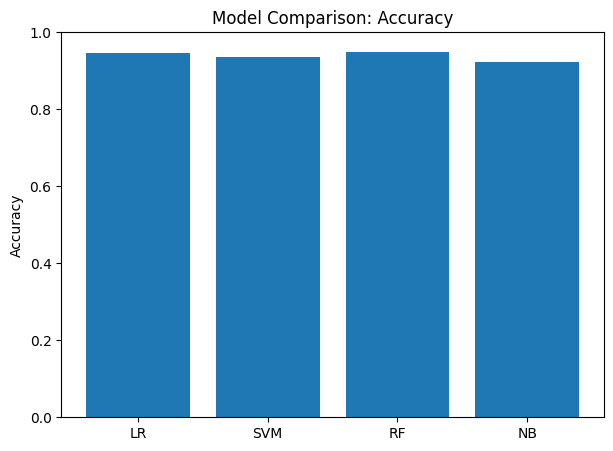

In [22]:
import matplotlib.pyplot as plt

models = ["LR", "SVM", "RF", "NB"]
test_accuracies = [
    test_accuracy_lr,
    test_accuracy_svm,
    test_accuracy_rf,
    test_accuracy_nb
]

plt.figure(figsize=(7,5))
plt.bar(models, test_accuracies)
plt.title("Model Comparison: Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()
